In [30]:
from scipy.ndimage.filters import convolve as filter2
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import io
import os
import time
%matplotlib inline

In [31]:
image_dir = 'images'
if not os.path.exists(image_dir):
  os.makedirs(image_dir)
content_dir = "{0}".format(os.getcwd())
image_path = content_dir+"/"+image_dir

**Extract frames from video**

In [32]:
def extractImages(pathIn, pathOut, limit = None):
  # img_width = 1280
  # img_height = 720
  for f in os.listdir(pathOut):
      os.remove(os.path.join(pathOut, f))
  count = 1
  vidcap = cv2.VideoCapture(pathIn)
  success,image = vidcap.read()
  success = True
  while success:
    vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*100))    # added this line 
    success,image = vidcap.read()
    # print ('Read a new frame: ', success)
    # print(image)
    if(success):
      # cv2.imwrite( pathOut + "/frame_%d.jpg" % count, image)     # save frame as JPEG file
      img_encoded = cv2.imencode('.jpg', image)[1]
      img_bytes = img_encoded.tobytes()
      img = Image.open(io.BytesIO(img_bytes))
      # img = img.resize((img_width, img_height), Image.ANTIALIAS)
      img.save(pathOut+"/image_%d.jpg"%(count))
      if(limit != None and count >= limit):
        break
      count = count + 1


In [5]:
pathIn = content_dir+"/video1.mp4"
extractImages(pathIn, image_path)

**Converting rgb color image to gray-scale.**

In [33]:
def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

**Necessary kernels**

[Kernel idea](https://drive.google.com/file/d/1OS8qTpdTLHEqzn4eRf5rrDhqYd6AyJUX/view?usp=sharing)

In [55]:

KERNEL_WEIGHT_AVG = np.array([[1/12, 1/6, 1/12],
                   [1/6, 0, 1/6],
                   [1/12, 1/6, 1/12]], float)

KERNEL_X = np.array([[-1, 1],
                    [-1, 1]]) * 0.25 # kernel for computing d/dx

KERNEL_Y = np.array([[-1, -1],
                    [1, 1]]) * 0.25 # kernel for computing d/dy

KERNEL_T = np.array([[2, 2],
                     [2, 2]]) * 0.25 # kernel for computing d/dt

**Computing Derivaties of two image, with respect to x, y and t.**

In [42]:
def computeDerivatives(im1, im2):
  fx = filter2(im1, KERNEL_X) + filter2(im2, KERNEL_X)
  fy = filter2(im1, KERNEL_Y) + filter2(im2, KERNEL_Y)

  # ft = im2 - im1
  ft = filter2(im1, KERNEL_T) + filter2(im2, -KERNEL_T)

  return fx, fy, ft

**Horn and Schunck algorithm**

In [43]:
def hornSchunck(im1, im2, *, alpha= 0.001, iter=8):

  im1 = im1.astype(np.float32)
  im2 = im2.astype(np.float32)
  # im1 = im1/255.0
  # im2 = im2/255.0

  # set up initial velocities for flow vectors
  u = np.zeros([im1.shape[0], im1.shape[1]])
  v = np.zeros([im1.shape[0], im1.shape[1]])

  # Estimate derivatives
  [fx, fy, ft] = computeDerivatives(im1, im2)
  
  for i in range(iter):
    # print(i)
    uAvg = filter2(u, KERNEL_WEIGHT_AVG)
    vAvg = filter2(v, KERNEL_WEIGHT_AVG)
    P = (fx*uAvg + fy*vAvg + ft)
    D = (alpha**2 + fx**2 + fy**2)
    P_D = P / D
    u = uAvg - fx * P_D
    v = vAvg - fy * P_D

  return u, v

**Draw motion vectors u and v into a image**

In [37]:
def draw(image, u, v, limit=5):
  color = (0, 0, 255)
  thickness = 1
  for i in range(0, len(u), 5):
    for j in range(0, len(u[0]), 5):
      if(u[i][j] != 0 and v[i][j] != 0):
        new_i = i + u[i][j]
        new_j = j + v[i][j]
        if(abs(new_j - j) >= limit or abs(new_i - i) >= limit):
          image = cv2.arrowedLine(image, (j, i), (int(new_j), int(new_i)), color, thickness)
  return image

## Experiment without Gaussian smoothing

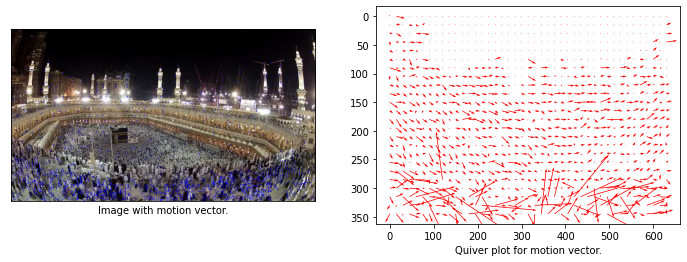

In [71]:
img1 = plt.imread(content_dir + "/image1.jpg")
img2 = plt.imread(content_dir + "/image2.jpg")
im1 = np.array(rgb2gray(img1))
im2 = np.array(rgb2gray(img2))

uv = hornSchunck(im1, im2, alpha=10, iter=20)

u = uv[0]
v = uv[1] 
image = draw(img1, u, v,2)

fig = plt.figure(figsize=(12, 4))

fig.add_subplot(121)
plt.imshow(image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel("Image with motion vector.")

r, c, _ = img1.shape
gd = 15
Y, X = np.mgrid[0:r:gd, 0:c:gd]
U=u[0:r:gd, 0:c:gd]
V=v[0:r:gd, 0:c:gd]
fig.add_subplot(122)
plt.quiver(X, Y, U, V, color='r')
plt.gca().invert_yaxis()
plt.xlabel("Quiver plot for motion vector.")
plt.savefig("output_frame.png")
plt.show()



## Experiment Gaussian smoothing

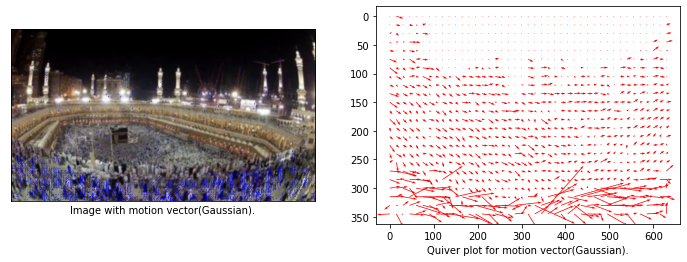

In [72]:
img1 = plt.imread(content_dir + "/image1.jpg")
img2 = plt.imread(content_dir + "/image2.jpg")
img1 = cv2.GaussianBlur(img1, (5, 5), 0)
img2 = cv2.GaussianBlur(img2, (5, 5), 0)
im1 = np.array(rgb2gray(img1))
im2 = np.array(rgb2gray(img2))

uv = hornSchunck(im1, im2, alpha=10, iter=20)

u = uv[0]
v = uv[1] 
image = draw(img1, u, v,2)

fig = plt.figure(figsize=(12, 4))

fig.add_subplot(121)
plt.imshow(image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel("Image with motion vector(Gaussian).")

r, c, _ = img1.shape
gd = 15
Y, X = np.mgrid[0:r:gd, 0:c:gd]
U=u[0:r:gd, 0:c:gd]
V=v[0:r:gd, 0:c:gd]
fig.add_subplot(122)
plt.quiver(X, Y, U, V, color='r')
plt.gca().invert_yaxis()
plt.xlabel("Quiver plot for motion vector(Gaussian).")

plt.savefig("output_frame_gaussian.png")
plt.show()


## Quiver plots for diffrent alpha and diffrent #no iterations (Without Gaussian)

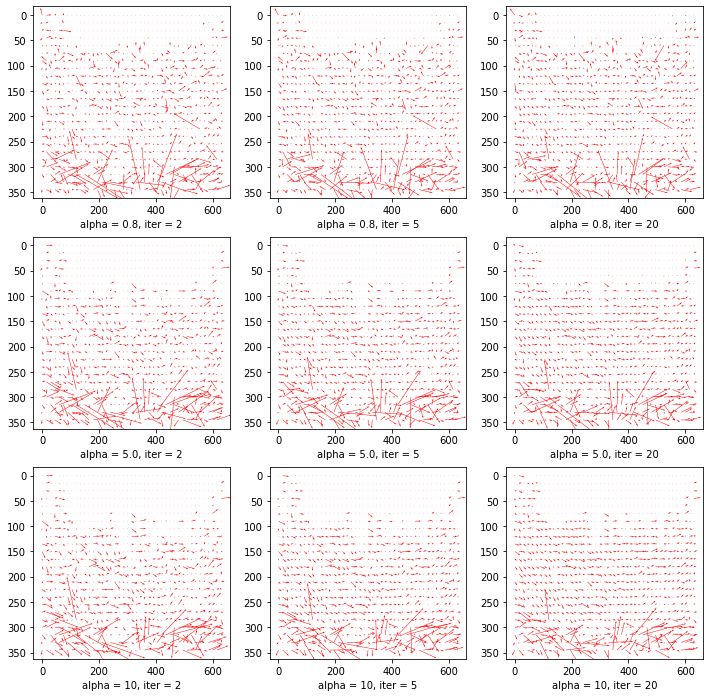

In [73]:
img1 = plt.imread(content_dir + "/image1.jpg")
img2 = plt.imread(content_dir + "/image2.jpg")
im1 = np.array(rgb2gray(img1))
im2 = np.array(rgb2gray(img2))

alphas = [0.8, 5.0, 10]
iterations = [2, 5, 20]
fig = plt.figure(figsize=(12, 12))
row = len(alphas)
col = len(iterations)
for i in range(row):
  alpha = alphas[i]
  for j in range(col):
    iter = iterations[j]
    uv = hornSchunck(im1, im2, alpha=alpha, iter=iter)
    u = uv[0]
    v = uv[1] 
    r, c,_ = np.shape(img1)
    gd = 15
    Y, X = np.mgrid[0:r:gd, 0:c:gd]
    U=u[0:r:gd, 0:c:gd]
    V=v[0:r:gd, 0:c:gd]

    fig.add_subplot(row,col, (i * col) + j + 1)
    plt.quiver(X, Y, U, V, color='r')
    plt.xlabel("alpha = %s, iter = %s"%(alpha, iter))
    plt.gca().invert_yaxis()
plt.savefig("quivers_without_gaussian.png")
plt.show()


## Quiver plots for diffrent alpha and diffrent #no iterations (With Gaussian)

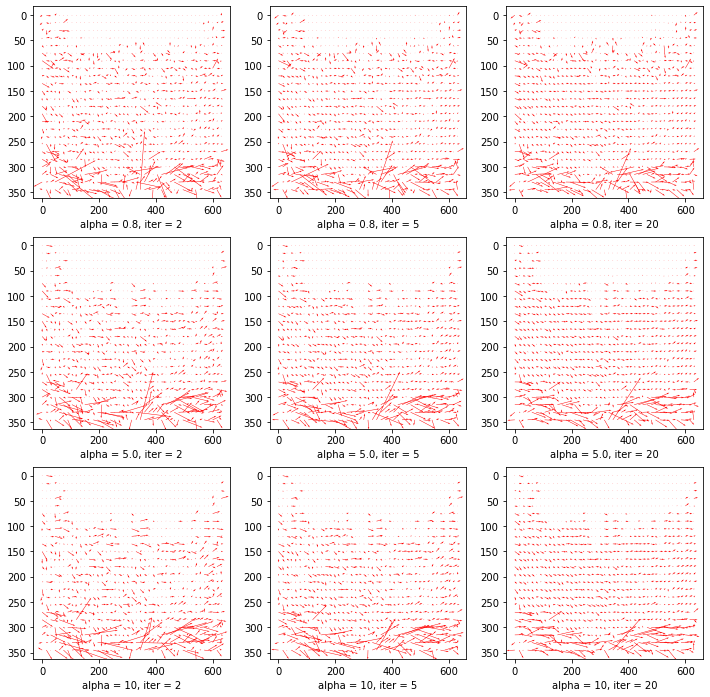

In [74]:
img1 = plt.imread(content_dir + "/image1.jpg")
img2 = plt.imread(content_dir + "/image2.jpg")
img1 = cv2.GaussianBlur(img1, (5, 5), 0)
img2 = cv2.GaussianBlur(img2, (5, 5), 0)
im1 = np.array(rgb2gray(img1))
im2 = np.array(rgb2gray(img2))

alphas = [0.8, 5.0, 10]
iterations = [2, 5, 20]
fig = plt.figure(figsize=(12, 12))
row = len(alphas)
col = len(iterations)
for i in range(row):
  alpha = alphas[i]
  for j in range(col):
    iter = iterations[j]
    uv = hornSchunck(im1, im2, alpha=alpha, iter=iter)
    u = uv[0]
    v = uv[1] 
    r, c,_ = np.shape(img1)
    gd = 15
    Y, X = np.mgrid[0:r:gd, 0:c:gd]
    U=u[0:r:gd, 0:c:gd]
    V=v[0:r:gd, 0:c:gd]

    fig.add_subplot(row,col, (i * col) + j + 1)
    plt.quiver(X, Y, U, V, color='r')
    plt.xlabel("alpha = %s, iter = %s"%(alpha, iter))
    plt.gca().invert_yaxis()
plt.savefig("quivers_with_gaussian.png")
plt.show()


## Optical flow for a video file

In [68]:
def optical_flow_video(pathIn, pathOut):
  image_arr = os.listdir(image_path)
  
  prev_image = cv2.imread(image_path+"/image_1.jpg")

  img_width = prev_image.shape[1]
  img_height = prev_image.shape[0]
  fourcc = cv2.VideoWriter_fourcc(*'MJPG')
  output = cv2.VideoWriter(pathOut, fourcc, 10,(img_width, img_height))
  
  prev_image = cv2.GaussianBlur(prev_image, (5, 5), 0)
  for count in range(2, len(image_arr)):
    prev_frame = np.array(rgb2gray(prev_image))
    # vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*50))    # added this line 
    image = cv2.imread(image_path+"/image_"+str(count)+".jpg")
    image = cv2.GaussianBlur(image, (5, 5), 0)
    curr_frame = np.array(rgb2gray(image))
    uv = hornSchunck(prev_frame, curr_frame, alpha=10, iter=20)
    u = uv[0]
    v = uv[1]
    output_image = draw(prev_image, u, v, 3)
    output.write(output_image)
    # if(count >= 100):
    #   break

    prev_image = image
  print("Complete")
  output.release()


In [69]:
pathIn = content_dir+"/video1.mp4"
extractImages(pathIn, image_path)
pathOut = content_dir + "/output_video1.mp4"
optical_flow_video(pathIn, pathOut)

Complete


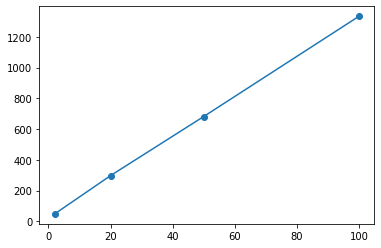

In [67]:
x = np.array([2, 20, 50, 100])
y = []
for j in range(len(x)):
  times = []
  for i in range(1, 50):
    img1 = plt.imread(image_path + "/image_"+str(i)+".jpg")
    img2 = plt.imread(image_path + "/image_"+str(i+1)+".jpg")

    im1 = np.array(rgb2gray(img1))
    im2 = np.array(rgb2gray(img2))
    t1 = time.time() 
    uv = hornSchunck(im1, im2, alpha=10, iter=x[j])
    t2 = time.time()
    t = (t2 - t1) * 1000
    times.append(t)
  y.append(np.mean(np.array(times)))

y = np.array(y)
plt.plot(x, y)
plt.scatter(x,y)
plt.savefig("performance.png")